# Imports


In [1]:
# pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [2]:
import site

In [3]:
site.getsitepackages()

['/opt/conda/lib/python3.7/site-packages']

In [4]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

# Projection Head
The projection head will project the embeddings generated by the image and text encoders to a vector of the same size


In [5]:
def make_projection_head(embedding_size, projection_size,num_layers,dropout_rate,name='projection_head'):
    input=keras.Input(shape=(embedding_size))
    projection=layers.Dense(projection_size)(input)

    for i in range(num_layers): 
        x = tf.nn.gelu(projection)
        x = layers.Dense(projection_size)(x)
        x = layers.Dropout(dropout_rate)(x) 
        x = layers.Add()([projection,x])
        projection=layers.LayerNormalization()(x)
    return keras.Model(inputs=input,outputs=projection,name=name)
    

## Projection head overview

2022-07-11 19:35:51.497113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 19:35:51.562694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 19:35:51.563642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 19:35:51.565268: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "projection_head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 788)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          100992      ['input_1[0][0]']                
                                                                                                  
 tf.nn.gelu (TFOpLambda)        (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['tf.nn.gelu[0][0]']             
                                                                                    

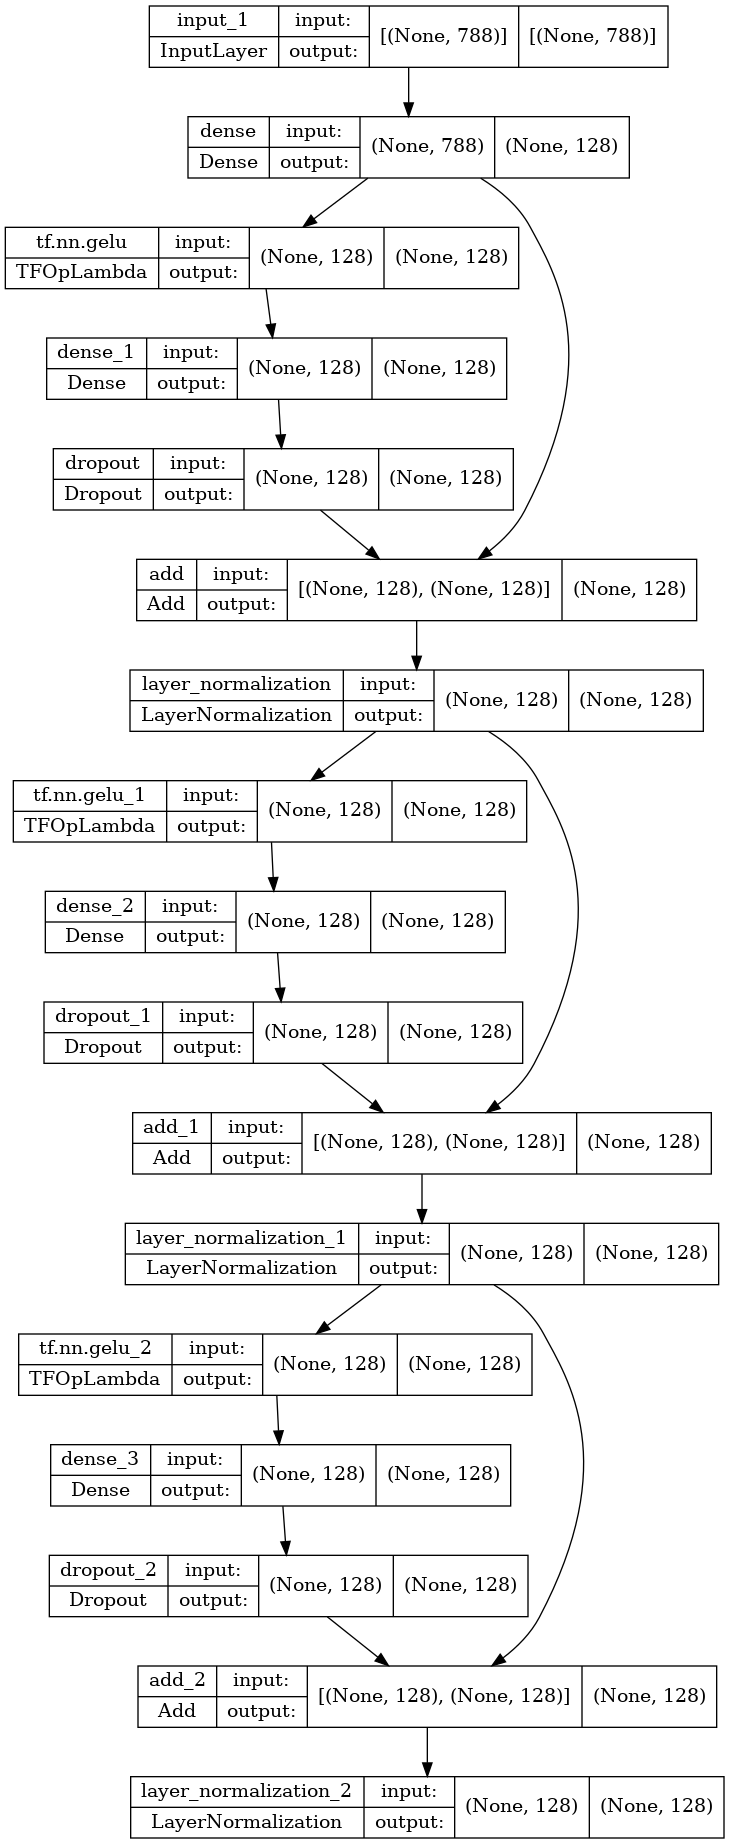

In [6]:
model=make_projection_head(788,128,3,0.2)
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)


# Text encoder
The text encoder uses BERT as a base model to generate embeddings. 
Link to model:  
https://tfhub.dev/google/collections/bert/1

The model is set to be either trainable or non trainable according to the experiment

In [7]:

def make_text_encoder(projection_size=128,
                      projection_layers=3,
                      dropout_rate=0.2,
                      trainable=False):
    # Importing Bert
    preprocessor_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    bert_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    bert_preprocessor=hub.KerasLayer(preprocessor_url,name='bert_preprocessor')
    bert=hub.KerasLayer(bert_url,name='bert')

    # Set up Bert trainability
    bert.trainable=trainable

    # Building functional model
    input=tf.keras.Input(shape=(),dtype=tf.dtypes.string,name='texts')
    x=bert_preprocessor(input)
    x=bert(x)['pooled_output']
    

    x=make_projection_head(embedding_size=x.shape[-1],
                           projection_size=projection_size,
                           num_layers=projection_layers,
                           dropout_rate=dropout_rate,
                           name='text_projection_head')(x)
    return tf.keras.Model(inputs=input,outputs=x,name='text_encoder')



In [8]:
model=make_text_encoder(projection_size=128,projection_layers=3,trainable=False)

## Text encoder overview

Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 texts (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 bert_preprocessor (KerasLayer)  {'input_word_ids':   0          ['texts[0][0]']                  
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                               

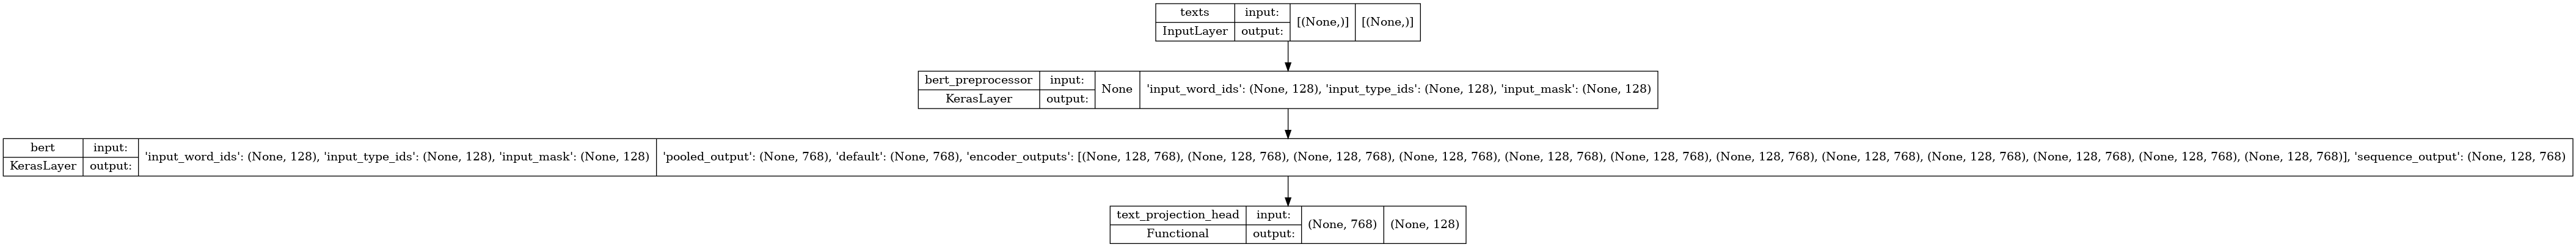

In [9]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.input

<KerasTensor: shape=(None,) dtype=string (created by layer 'texts')>

# Image encoder



In [11]:
def make_image_encoder( input_shape=(299,299,3),
                        projection_size=128,
                        projection_layers=3,
                        dropout_rate=0.2,
                        trainable=False, 
                        backbone='resnet50',
                        weights='imagenet',
                        backbone_pooling='avg'):
    # Set up the backbone
    if backbone=='xception':
        backbone_model=tf.keras.applications.Xception(
                include_top=False,
                weights=weights,
                pooling=backbone_pooling
        )
    if backbone=='resnet50':
        backbone_model=tf.keras.applications.ResNet50(
            include_top=False,
            weights=weights,
            pooling=backbone_pooling
        )

    # Set the trainability of the backbone
    for layer in backbone_model.layers:
        layer.trainable=trainable 
    
    # Functional model definition
    input=tf.keras.Input(shape=input_shape,name='images')
    x=backbone_model(input)
    x=make_projection_head(embedding_size=x.shape[-1],
                           projection_size=projection_size,
                           num_layers=projection_layers,
                           dropout_rate=dropout_rate,
                           name='image_projection_head')(x)
    return tf.keras.Model(inputs=input,outputs=x, name='image_encoder')



## Image encoder overview

In [12]:
model=make_image_encoder(backbone='resnet50')

Model: "image_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 299, 299, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 image_projection_head (Func  (None, 128)              312576    
 tional)                                                         
                                                                 
Total params: 23,900,288
Trainable params: 312,576
Non-trainable params: 23,587,712
_________________________________________________________________


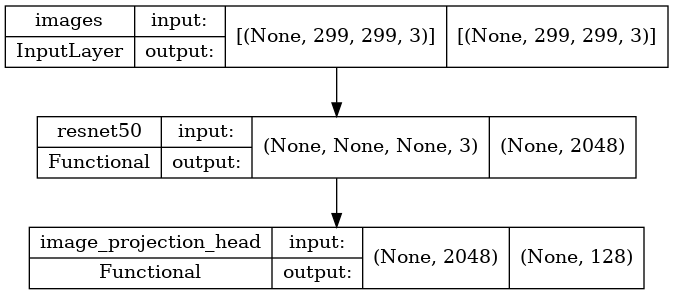

In [13]:
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

# Dual Encoder

## Building model

In [14]:
def make_dual_encoder(image_encoder,text_encoder,temperature=0.2):
    def clip_loss(caption_embeddings, image_embeddings,temperature=temperature):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True,name='image_sim'
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2
    image_input=tf.keras.Input(tensor=image_encoder.input,name='images')
    text_input= tf.keras.Input(tensor=text_encoder.input,name='texts')

    img_encoding=image_encoder(image_input)
    txt_encoding=text_encoder(text_input)

    
    model=tf.keras.Model(inputs=[image_input,text_input],outputs=[img_encoding,txt_encoding],name='clip')
    loss=clip_loss(txt_encoding,img_encoding)
    model.add_loss(loss)




    return model


# Train model with COCO

## Data input pipeline

In [15]:
data,info=tfds.load(name='coco_captions',with_info=True)

In [16]:
def get_image(dataset):
    img=dataset['image']
    img=img/255
    img=tf.image.resize(img,[299,299])
    return img
def get_capt(dataset):
    caption=dataset['captions']['text'][0]
    return caption

In [17]:
imgs=data['train'].map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
capts=data['train'].map(get_capt,num_parallel_calls=tf.data.AUTOTUNE)
data=tf.data.Dataset.zip((imgs,capts))
data=tf.data.Dataset.zip((data,)).shuffle(100).batch(64).prefetch(tf.data.AUTOTUNE)


## Training

Define a training scheduler

In [18]:
def schedule(epoch):
    return 1e-6*10**(epoch/5)

In [19]:
pwd

'/home/jupyter/MedClip/src'

Train the model

In [20]:
img_encoder=make_image_encoder(input_shape=(299,299,3),projection_layers=1,projection_size=64)
txt_encoder=make_text_encoder(projection_layers=1,projection_size=64)
opt = keras.optimizers.Adam(learning_rate=4e-6)
clip=make_dual_encoder(img_encoder,txt_encoder)
clip.compile(opt)
logdir='../model_logs/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
history=clip.fit(data.take(5),epochs=10,
                 callbacks=[tensorboard_callback])

Epoch 1/10


2022-07-11 19:36:56.762982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


5/5 [==============================] - 36s 2s/step - loss: 23.5101
Epoch 2/10
5/5 [==============================] - 11s 2s/step - loss: 24.9914
Epoch 3/10
5/5 [==============================] - 11s 2s/step - loss: 23.0756
Epoch 4/10
5/5 [==============================] - 11s 2s/step - loss: 25.0266
Epoch 5/10
5/5 [==============================] - 11s 2s/step - loss: 22.2270
Epoch 6/10
5/5 [==============================] - 11s 2s/step - loss: 23.9709
Epoch 7/10
5/5 [==============================] - 11s 2s/step - loss: 22.4195
Epoch 8/10
5/5 [==============================] - 11s 2s/step - loss: 21.5783
Epoch 9/10
5/5 [==============================] - 11s 2s/step - loss: 20.0147
Epoch 10/10
5/5 [==============================] - 11s 2s/step - loss: 22.7961


Display training history

In [21]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/MedClip/Models/CLIP tensorboards/clip_logs_fixed_lr'

Save the text encoder and the image encoder

In [22]:
save_path='/content/drive/MyDrive/MedClip/Models/Homemade clip/'
img_encoder.save(save_path+'image_encoder')
txt_encoder.save(save_path+'image_encoder')

2022-07-11 19:39:50.482128: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


PermissionDeniedError: /content; Permission denied

# Test the model

First generate image embeddings



In [ ]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")


def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))


print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Define a search function

In [ ]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

In [ ]:
!kill 337

In [ ]:
plt.plot(history.history['loss'])